In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import nu, fu
from numpy import nan
from pandas import (
    CategoricalDtype, DataFrame, Index, NaT, Series, concat, get_dummies, isna, notnull, read_csv, read_excel, to_datetime, to_numeric
)
from re import split, search, sub, MULTILINE
from scipy.stats import f_oneway, ttest_ind, kruskal, norm
import itertools
import os.path as osp
import re
import statsmodels.api as sm


## Use the CSV Data from the Last Successful Build

In [11]:

# load the CSV data frame from the last successful build
df_name = 'csv_stats_df'
data_frames_dict = nu.load_data_frames(
    verbose=True, **{df_name: ''}
)
csv_stats_df = data_frames_dict[df_name].copy()
print(csv_stats_df.shape)
print(sorted([cn for cn in csv_stats_df.columns if 'patient_id' in cn]))

No pickle exists for csv_stats_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/csv_stats_df.csv.
(158663, 125)
['injury_record_patient_id', 'injury_treated_patient_id', 'patient_id', 'player_gaze_patient_id', 'pulse_taken_patient_id', 'tag_applied_patient_id', 'tool_applied_patient_id', 'triage_level_walk_if_can_patient_id', 'triage_level_walked_patient_id', 'triage_level_wave_if_can_patient_id', 'triage_level_waved_patient_id']



## Use the is-military classifier to give every patient column a value between 0 and 1

In [12]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

is_military_classifier = nu.load_object('is_military_classifier')
is_military_tt = nu.load_object('is_military_tt')
is_military_cv = nu.load_object('is_military_cv')

In [14]:

for patient_id, patients_df in csv_stats_df.groupby('patient_id'):
    if any(map(lambda x: x in patient_id.lower(), ['civilian'])):
        is_military = 0.0
    elif any(map(lambda x: x in patient_id.lower(), ['officer', 'soldier', 'marine', 'military', 'navy'])):
        is_military = 1.0
    else:
        
        # Predict if its military
        X_test = is_military_tt.transform(is_military_cv.transform([patient_id])).toarray()
        is_military = is_military_classifier.predict_proba(X_test)[0][1]
    
    # Store the prediction in the predict_proba column
    csv_stats_df.loc[patients_df.index, 'is_military_prediction'] = is_military

In [16]:

mask_series = (csv_stats_df.is_military_prediction == 1.0) & ~csv_stats_df.patient_id.isnull()
sorted(csv_stats_df[mask_series].patient_id.unique())

['Local Soldier 1 Root', 'Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root', 'Open World Marine 1 Female Root', 'Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 2 Male Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root', 'US Soldier 1 Root']

In [17]:

mask_series = (csv_stats_df.is_military_prediction == 0.0) & ~csv_stats_df.patient_id.isnull()
sorted(csv_stats_df[mask_series].patient_id.unique())

['Adept Shooter Root', 'Adept Victim Root', 'Civilian 1 Female Root', 'Civilian 1 Root', 'Civilian 2 Root', 'NPC 1 Root', 'NPC 2 Root', 'NPC 3 Root', 'NPC 4 Root', 'NPC Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root', 'Patient U Root', 'Patient V Root', 'Patient W Root', 'Patient X Root', 'Simulation Root', 'bystander Root', 'electrician Root', 'patient U Root', 'patient V Root', 'patient W Root', 'patient X Root']

In [18]:

mask_series = (csv_stats_df.is_military_prediction < 1.0) & (csv_stats_df.is_military_prediction > 0.0) & ~csv_stats_df.patient_id.isnull()
sorted(csv_stats_df[mask_series].patient_id.unique())

[]

In [20]:

def get_actual_engagement_order(scene_df, include_noninteracteds=False, verbose=False):
    """
    Get the chronological order of engagement starts for each patient in a scene.
    
    Parameters:
        - scene_df (pandas.DataFrame): DataFrame containing scene data, including patient IDs, action types,
          action ticks, location IDs, patient sorts, and DTR triage priority model predictions.
        - verbose (bool, optional): If True, prints debug information. Default is False.
    
    Returns:
        - engagement_order (list): List of tuples containing engagement information ordered chronologically:
            - patient_id (int): The ID of the patient.
            - engagement_start (int): The action tick at which the engagement started.
            - location_tuple ((int, int)): A tuple representing the (x, z) coordinates of the engagement location.
            - patient_sort (str or None): The patient's SORT designation, if available.
            - is_military_prediction (float): The patient's predicted militariness
            - injury_severity (str): The patient's severity
    """
    engagement_starts_list = []
    for patient_id, patient_df in scene_df.groupby('patient_id'):
        
        # Get the cluster ID, if available
        mask_series = ~patient_df.patient_sort.isnull()
        patient_sort = (
            patient_df[mask_series].sort_values('action_tick').iloc[-1].patient_sort
            if mask_series.any()
            else None
        )
        
        # Get the is-military prediction
        if 'is_military_prediction' in patient_df.columns:
            mask_series = ~patient_df.is_military_prediction.isnull()
            predicted_military = (
                patient_df[mask_series].is_military_prediction.mean()
                if mask_series.any()
                else None
            )
        else: predicted_military = None
        
        # Get the maximum injury severity
        injury_severity = fu.get_maximum_injury_severity(patient_df)
        
        # Check if the responder even interacted with this patient
        mask_series = patient_df.action_type.isin(fu.responder_negotiations_list)
        if mask_series.any():
            df = patient_df[mask_series].sort_values('action_tick')
            
            # Get the first engagement start that has a location
            mask_series = ~df.location_id.isnull()
            if mask_series.any():
                engagement_start = df[mask_series].iloc[0].action_tick
                engagement_location = eval(df[mask_series].iloc[0].location_id) # Evaluate string to get tuple
                location_tuple = (engagement_location[0], engagement_location[2])
            else:
                engagement_start = df.iloc[0].action_tick
                location_tuple = (0.0, 0.0)
            
            # Add engagement information to the list
            engagement_tuple = (patient_id, engagement_start, location_tuple, patient_sort, predicted_military, injury_severity)
            engagement_starts_list.append(engagement_tuple)
        
        # Add -99999 for engagement_start if you're including non-interacted-with patients
        elif include_noninteracteds:
            engagement_tuple = (patient_id, -99999, None, patient_sort, predicted_military, injury_severity)
            engagement_starts_list.append(engagement_tuple)
    
    # Sort the starts list chronologically
    engagement_order = sorted(engagement_starts_list, key=lambda x: x[1], reverse=False)
    
    return engagement_order

In [19]:

[patients_df.is_military_prediction.unique().item() for patient_id, patients_df in csv_stats_df.groupby('patient_id')]

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [30]:

rows_list = []
groupby_columns = ['participant_id', 'session_uuid']
for (participant_id, session_uuid), session_df in csv_stats_df.groupby(groupby_columns):
    row_dict = {cn: eval(cn) for cn in groupby_columns}
    
    # Extract the actual and ideal sequences of first interactions from the scene in terms of is/isn't military
    engagement_starts_list = fu.get_actual_engagement_order(session_df)
    actual_sequence = []
    for engagement_tuple in engagement_starts_list:
        patient_id = engagement_tuple[0]
        if any(map(lambda x: x in patient_id.lower(), ['civilian'])):
            is_military = 0.0
        elif any(map(lambda x: x in patient_id.lower(), ['officer', 'soldier', 'marine', 'military', 'navy'])):
            is_military = 1.0
        else:
            X_test = is_military_tt.transform(is_military_cv.transform([patient_id])).toarray()
            is_military = is_military_classifier.predict_proba(X_test)[0][1]
        actual_sequence.append(is_military)
    ideal_sequence = sorted(actual_sequence)[::-1]
    
    # Calculate the R-squared adjusted value as a measure of right ordering
    measure_of_right_ordering = fu.get_measure_of_ordering(Series(actual_sequence), Series(ideal_sequence))
    row_dict['measure_of_right_ordering'] = measure_of_right_ordering

    rows_list.append(row_dict)
right_ordering_df = DataFrame(rows_list)

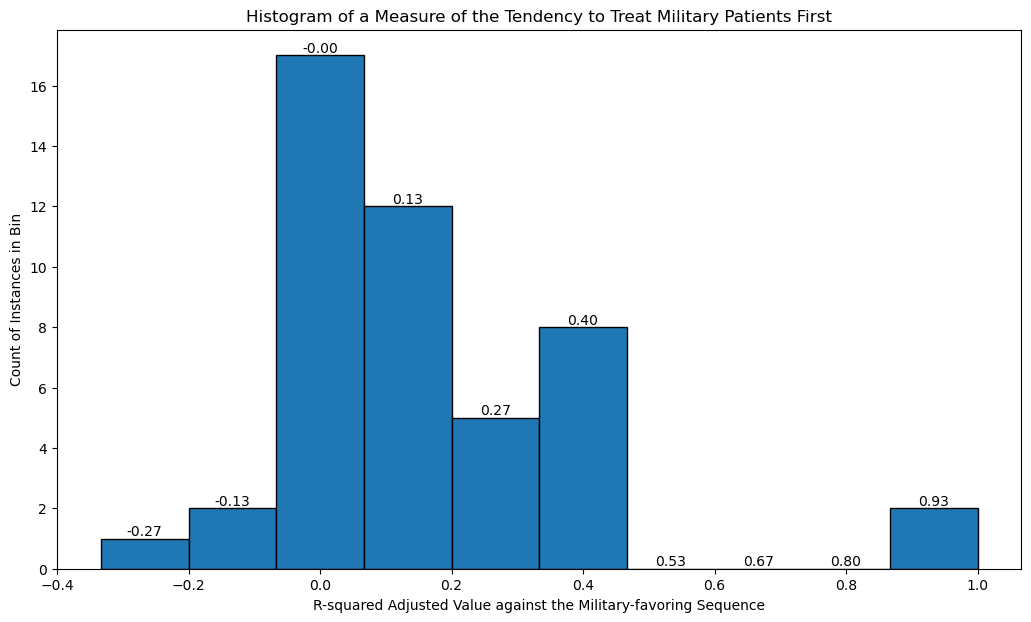

In [53]:

from matplotlib import colors as colors, pyplot as plt
import humanize

fig_height = 7
fig_size=(nu.twitter_aspect_ratio*fig_height, fig_height)
fig, ax = plt.subplots(figsize=fig_size)
axes_subplot_obj = right_ordering_df.measure_of_right_ordering.hist(ax=ax, align='mid', edgecolor='black')

# Display x value of each bar on bar
bars_collection = axes_subplot_obj.patches
for rect in bars_collection:
    height = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2.0
    ax.text(x_value, height, f'{x_value:0.2f}', ha='center', va='bottom')

# Set the grid, title, and labels
plt.grid(False)
ax.set_title('Histogram of a Measure of the Tendency to Treat Military Patients First')
ax.set_xlabel('R-squared Adjusted Value against the Military-favoring Sequence')
ax.set_ylabel('Count of Instances in Bin');

In [51]:

dir(rect)

['_PROPERTIES_EXCLUDED_FROM_SET', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alias_map', '_alpha', '_animated', '_antialiased', '_axes', '_bind_draw_path_function', '_callbacks', '_capstyle', '_clipon', '_clippath', '_cm_set', '_convert_units', '_convert_xy_units', '_dashes', '_dashoffset', '_default_contains', '_edge_default', '_edgecolor', '_facecolor', '_fill', '_get_clipping_extent_bbox', '_gid', '_hatch', '_hatch_color', '_height', '_in_layout', '_joinstyle', '_label', '_linestyle', '_linewidth', '_mouseover', '_original_edgecolor', '_original_facecolor', '_path_effects', '_picker', '_process_radius', '_rasterized', '_remove_method', '_set_alpha_for_arr